# Evaluating receiver performance through simulation

* A key performance parameter of a communication system is the bit-error rate (BER)
* Simulated transmission and reception can be used to measure the error rate
  - we will learn later that in many cases, the BER can be computed
* once we have simulations working, we will study the impact of SNR, pulse-shape, over-sampling factor, and constellation on the error rate.

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "talk"
sns.set_theme(context=sns_context, style="ticks")

In [2]:
## imports from the comms module
from comms.sources import random_bit_source, count_errors, string_source, string_sink
from comms.pulse_shaping import rect_pulse, sine_squared_pulse, manchester_pulse, pulse_shape, matched_filter
from comms.mod_mapping import mod_mapper, PAM4, energy_per_bit, BPSK, QPSK, demodulator, plot_constellation
from comms.utils import Q

Last time, we performed a simple simulation; a short text message was transmitted.

Based on that example, we will develop our simulation system.

Here is the code from last time:

In [3]:
## message and system parameters
message = 'ECE 460 is my favorite class'
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = PAM4

# transmitter
bits = string_source(message)
symbols = mod_mapper(bits, constellation)
tx_sig = pulse_shape(symbols, pulse, fsT)

# channel
SNR = 20
noise_var = energy_per_bit(constellation) /SNR
noise_samples = (np.sqrt(0.5*noise_var) * 
                 (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

rx_sig = tx_sig + noise_samples

# receiver
hat_s = matched_filter(rx_sig, pulse, fsT)
rx_bits = demodulator(hat_s, constellation)
string_sink(rx_bits)

'ECE 460 is my favorite class'

Our goal is to estimate the rate of bit errors, i.e., the ratio of the number $N_e$ of bits received in error to the number $M$ of transmitted bits.

We can find the number of errors and the number of bits for the above example as follows and from that we can estimate the rate $P_e$.

In [4]:
Ne = np.sum(rx_bits != bits)
M = len(bits)

print(f'Found {Ne} errors in {M} transmitted bits; estimated error rate is {Ne/M:6.5f}')

Found 0 errors in 224 transmitted bits; estimated error rate is 0.00000


### We need to simulate more bits

* The estimate above is not reliable: is the rate of errors really 0, or is it close to $10^{-4}$, or something else? We just can't tell, all we can say with some confidence is that the error rate is probably smaller that $1/224$.

* So, how many bits do we need to simulate? It can be shown that if we want high confidence that our estimate is close to the true error rate, we should simulate until we have found approximately 400 errors. Specifically, with that choice, our estimate will be within 10% of the true value (with 95% probability). For example, if the true value of the error rate is 0.001, then our estimate will be (very likely) between 0.00099 and 0.0011.

* There is a caveat, though. The expected number of bits that need to be simulated to collect 400 errors is $M=\frac{400}{P_e}$. That number is very large when $P_e$ is very small. For example, if the error rate is $10^{-10}$, then we have to expect that we need to simulate $4\cdot 10^{12}$ bits. That will take a very long time - days, if not weeks. To work around this issue, we limit the number of bits to transmit and accept that the error estimate is not very reliable. For example, if we limit the number of simulated bits to $M=4 \cdot 10^{6}$, then error estimates smaller than $10^{-4}$ will not be as reliable.

* To incorporate these considerations, we make the following changes:
  + wrap a while loop around the code simulating transmission and reception
  + introduce counters for the number of errors and number of transmitted bits
  + use these counters in the stop criterion for the while loop
  + instead of using a source that generates bits from a string, we generate bits randomly (using `random_bit_source()`)

* we also change the modulation to BPSK and the SNR to 5; this is equal to 7dB ($10 \log_{10}(5) = 7$).

In [5]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = BPSK # {0b00: 1+1j, 0b01: 1-1j, 0b10: -1-1j, 0b11: -1+1j}# QPSK

SNR = 5

In [6]:
# counters
Ne = 0
M = 0

while Ne < 400 and M < 1e6:
    # transmitter
    bits = random_bit_source(N_burst)
    symbols = mod_mapper(bits, constellation)
    tx_sig = pulse_shape(symbols, pulse, fsT)

    # channel

    noise_var = energy_per_bit(constellation) /SNR
    noise_samples = (np.sqrt(0.5*noise_var) * 
                    (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

    rx_sig = tx_sig + noise_samples

    # receiver
    hat_s = matched_filter(rx_sig, pulse, fsT)
    rx_bits = demodulator(hat_s, constellation)

    this_Ne = np.sum(rx_bits != bits)

    # update counters
    Ne += this_Ne
    M += N_burst

print(f"SNR = {10*np.log10(SNR):3.1f} dB: found {Ne} error in {M} bits; rate = {Ne/M:4.2e}")

SNR = 7.0 dB: found 401 error in 503808 bits; rate = 7.96e-04


**Question:** how good is the above estimate? 

For BPSK, we will learn later that the bit error rate can be compute from Gaussian probability distributions. Here is the exact error rate:

In [7]:
print(f'The exact bit error rate for BPSK and SNR = {10*np.log10(SNR):3.1f} dB: {Q(np.sqrt(2*SNR)):4.2e}')

The exact bit error rate for BPSK and SNR = 7.0 dB: 7.83e-04


Our estimate is very close to the true error rate! So, our simulation method appears to work.

### Looping over SNR

* Let's add one more feature: we want to be able to estimate bit error rate as a function of SNR.

* For that purpose, we need to add another loop - over a range of SNR values.
  - For each SNR value, we store the number of errors and the number of transmitted bits

In [8]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = BPSK

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 8.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

In [9]:
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

SNR = 0.0 dB: found 642 error in 8192 bits; rate = 0.07837
SNR = 0.5 dB: found 492 error in 8192 bits; rate = 0.06006
SNR = 1.0 dB: found 494 error in 8192 bits; rate = 0.06030
SNR = 1.5 dB: found 545 error in 12288 bits; rate = 0.04435
SNR = 2.0 dB: found 459 error in 12288 bits; rate = 0.03735
SNR = 2.5 dB: found 446 error in 16384 bits; rate = 0.02722
SNR = 3.0 dB: found 469 error in 20480 bits; rate = 0.02290
SNR = 3.5 dB: found 437 error in 24576 bits; rate = 0.01778
SNR = 4.0 dB: found 425 error in 32768 bits; rate = 0.01297
SNR = 4.5 dB: found 423 error in 45056 bits; rate = 0.00939
SNR = 5.0 dB: found 412 error in 69632 bits; rate = 0.00592
SNR = 5.5 dB: found 401 error in 102400 bits; rate = 0.00392
SNR = 6.0 dB: found 404 error in 176128 bits; rate = 0.00229
SNR = 6.5 dB: found 400 error in 290816 bits; rate = 0.00138
SNR = 7.0 dB: found 401 error in 450560 bits; rate = 0.00089
SNR = 7.5 dB: found 401 error in 999424 bits; rate = 0.00040
SNR = 8.0 dB: found 196 error in 10035

* Let's plot this.
  + since the error rates are getting very small at higher SNR, they must be plotted on a logarithmic scale 
    - otherwise, they all just look like they're close to zero
* we plot the simulated error rate and the theoretical, true error rate

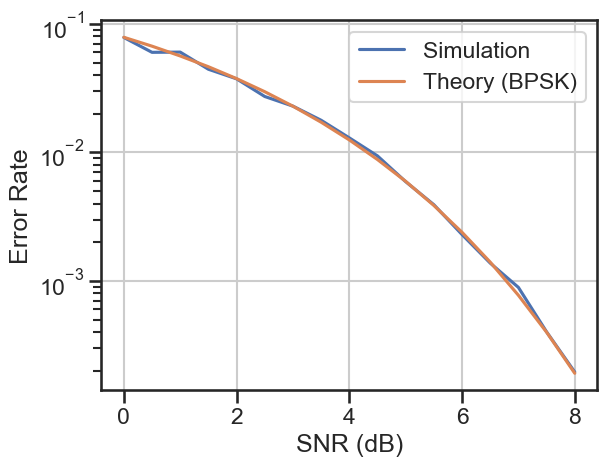

In [10]:
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

* There is excellent agreement between simulation and theory - that's very good news and validates the simulation approach. 

* The obvious down-side is that it takes a while to run the simulation.
  + this only gets worse with decreasing error rates or increased system complexity.

## Looking at the impact of system parameters

* We now have a tool that we can leverage to gain insight into the impact of different system parameters, we will look at the impact of
  + pulse shape
  * oversampling factor
  * constellation
  * modulation mapping

* Throughout, we keep the theoretical BPSK curve in place as a reference.

### Pulse shape

We change the pulse shape from sine-squared to rectangular and measure the error rate.

In [11]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 16
pulse = rect_pulse(fsT)
constellation = BPSK

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 8.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

In [12]:
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

SNR = 0.0 dB: found 672 error in 8192 bits; rate = 0.08203
SNR = 0.5 dB: found 532 error in 8192 bits; rate = 0.06494
SNR = 1.0 dB: found 441 error in 8192 bits; rate = 0.05383
SNR = 1.5 dB: found 573 error in 12288 bits; rate = 0.04663
SNR = 2.0 dB: found 490 error in 12288 bits; rate = 0.03988
SNR = 2.5 dB: found 518 error in 16384 bits; rate = 0.03162
SNR = 3.0 dB: found 456 error in 20480 bits; rate = 0.02227
SNR = 3.5 dB: found 470 error in 28672 bits; rate = 0.01639
SNR = 4.0 dB: found 434 error in 36864 bits; rate = 0.01177
SNR = 4.5 dB: found 409 error in 49152 bits; rate = 0.00832
SNR = 5.0 dB: found 420 error in 69632 bits; rate = 0.00603
SNR = 5.5 dB: found 408 error in 114688 bits; rate = 0.00356
SNR = 6.0 dB: found 401 error in 176128 bits; rate = 0.00228
SNR = 6.5 dB: found 409 error in 290816 bits; rate = 0.00141
SNR = 7.0 dB: found 402 error in 487424 bits; rate = 0.00082
SNR = 7.5 dB: found 400 error in 974848 bits; rate = 0.00041
SNR = 8.0 dB: found 183 error in 10035

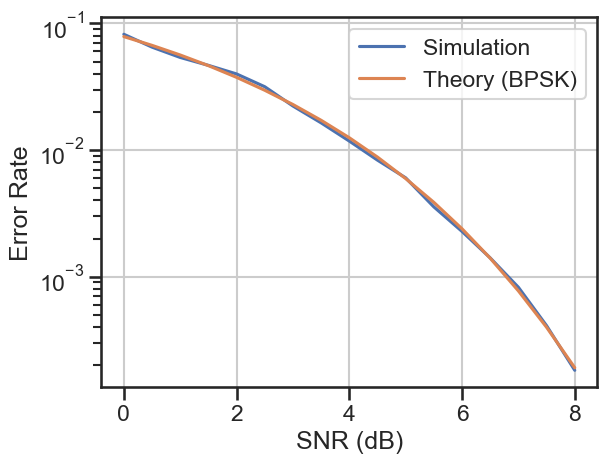

In [13]:
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

No change! 

**Insight:** the pulse shape does NOT affect the error rate!

### Oversampling factor `fsT`

Doe the oversampling factor $f_sT$ affect the error rate? Let's see what happens when `fsT` is changed from 16 to 4?

SNR = 0.0 dB: found 679 error in 8192 bits; rate = 0.08289
SNR = 0.5 dB: found 554 error in 8192 bits; rate = 0.06763
SNR = 1.0 dB: found 452 error in 8192 bits; rate = 0.05518
SNR = 1.5 dB: found 559 error in 12288 bits; rate = 0.04549
SNR = 2.0 dB: found 436 error in 12288 bits; rate = 0.03548
SNR = 2.5 dB: found 497 error in 16384 bits; rate = 0.03033
SNR = 3.0 dB: found 449 error in 20480 bits; rate = 0.02192
SNR = 3.5 dB: found 446 error in 24576 bits; rate = 0.01815
SNR = 4.0 dB: found 442 error in 32768 bits; rate = 0.01349
SNR = 4.5 dB: found 423 error in 45056 bits; rate = 0.00939
SNR = 5.0 dB: found 416 error in 61440 bits; rate = 0.00677
SNR = 5.5 dB: found 411 error in 106496 bits; rate = 0.00386
SNR = 6.0 dB: found 406 error in 163840 bits; rate = 0.00248
SNR = 6.5 dB: found 402 error in 278528 bits; rate = 0.00144
SNR = 7.0 dB: found 401 error in 516096 bits; rate = 0.00078
SNR = 7.5 dB: found 377 error in 1003520 bits; rate = 0.00038
SNR = 8.0 dB: found 217 error in 1003

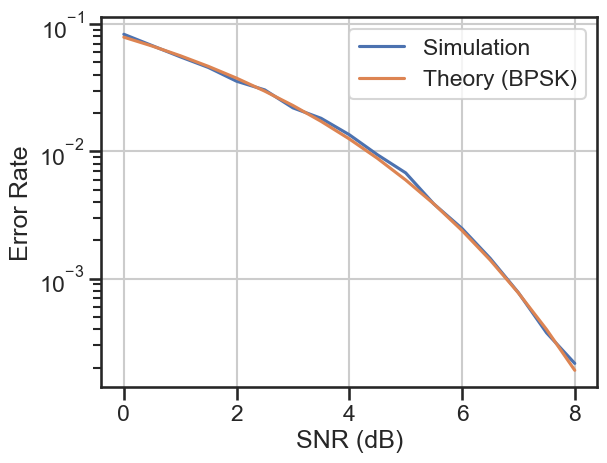

In [14]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 4
pulse = sine_squared_pulse(fsT)
constellation = BPSK

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 8.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

## the simulation loop
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

## plot
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

Again, there is no change!

* We can run these simulations at any oversampling factor we choose as long as we meet the Nyquist condition. 

* Smaller values of `fsT` leads to fewer samples and should be faster to simulate.

* Larger values of `fsT` allow more insight into signal structure.

* Usually, `fsT=4` is a good value.

### Impact of constellation

Let's look at the error rate for constellation other than BPSK. We'll look at 

* QPSK
* 4-PAM

#### QPSK

SNR = 0.0 dB: found 713 error in 8192 bits; rate = 0.08704
SNR = 0.5 dB: found 541 error in 8192 bits; rate = 0.06604
SNR = 1.0 dB: found 454 error in 8192 bits; rate = 0.05542
SNR = 1.5 dB: found 596 error in 12288 bits; rate = 0.04850
SNR = 2.0 dB: found 484 error in 12288 bits; rate = 0.03939
SNR = 2.5 dB: found 405 error in 12288 bits; rate = 0.03296
SNR = 3.0 dB: found 492 error in 20480 bits; rate = 0.02402
SNR = 3.5 dB: found 467 error in 24576 bits; rate = 0.01900
SNR = 4.0 dB: found 438 error in 36864 bits; rate = 0.01188
SNR = 4.5 dB: found 433 error in 49152 bits; rate = 0.00881
SNR = 5.0 dB: found 402 error in 73728 bits; rate = 0.00545
SNR = 5.5 dB: found 401 error in 102400 bits; rate = 0.00392
SNR = 6.0 dB: found 406 error in 172032 bits; rate = 0.00236
SNR = 6.5 dB: found 402 error in 262144 bits; rate = 0.00153
SNR = 7.0 dB: found 400 error in 557056 bits; rate = 0.00072
SNR = 7.5 dB: found 387 error in 1003520 bits; rate = 0.00039
SNR = 8.0 dB: found 193 error in 1003

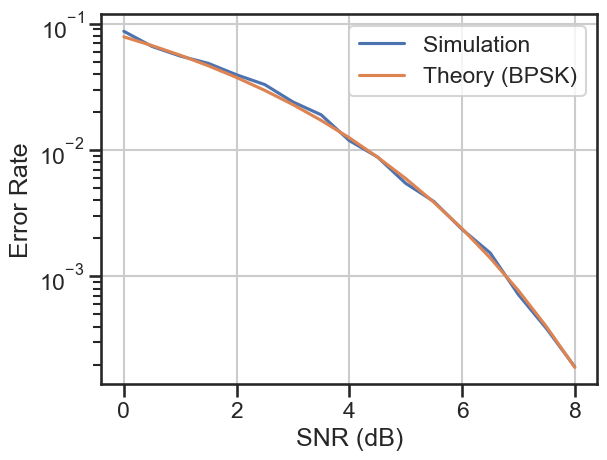

In [15]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = QPSK

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 8.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

## the simulation loop
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

## plot
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

Again, no change! Does that mean, the constellation does not affect the error rate? That can't be true or we could simply use very large constellations to transmit lots of bits at the same time.

Let's try 4-PAM.

#### 4-PAM

SNR = 0.0 dB: found 553 error in 4096 bits; rate = 0.13501
SNR = 0.5 dB: found 517 error in 4096 bits; rate = 0.12622
SNR = 1.0 dB: found 465 error in 4096 bits; rate = 0.11353
SNR = 1.5 dB: found 446 error in 4096 bits; rate = 0.10889
SNR = 2.0 dB: found 402 error in 4096 bits; rate = 0.09814
SNR = 2.5 dB: found 692 error in 8192 bits; rate = 0.08447
SNR = 3.0 dB: found 632 error in 8192 bits; rate = 0.07715
SNR = 3.5 dB: found 530 error in 8192 bits; rate = 0.06470
SNR = 4.0 dB: found 500 error in 8192 bits; rate = 0.06104
SNR = 4.5 dB: found 400 error in 8192 bits; rate = 0.04883
SNR = 5.0 dB: found 567 error in 12288 bits; rate = 0.04614
SNR = 5.5 dB: found 426 error in 12288 bits; rate = 0.03467
SNR = 6.0 dB: found 455 error in 16384 bits; rate = 0.02777
SNR = 6.5 dB: found 474 error in 20480 bits; rate = 0.02314
SNR = 7.0 dB: found 402 error in 24576 bits; rate = 0.01636
SNR = 7.5 dB: found 413 error in 32768 bits; rate = 0.01260
SNR = 8.0 dB: found 420 error in 40960 bits; rate 

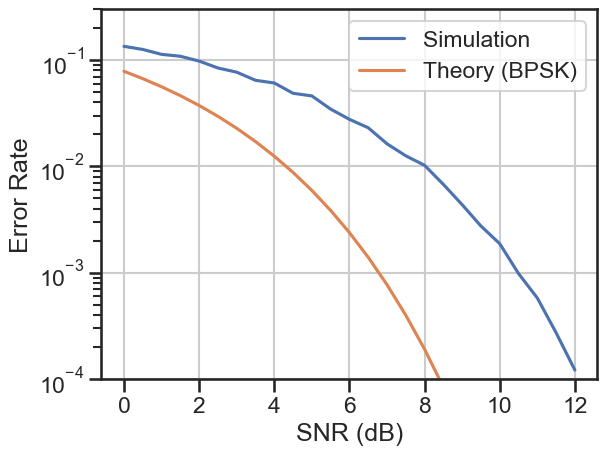

In [16]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 4
pulse = sine_squared_pulse(fsT)
constellation = PAM4

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 12.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

## the simulation loop
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

## plot
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.ylim(1e-4, 0.3)
plt.legend()

plt.show()

Finally! There is a significant difference in error rate between BPSK and 4-PAM.

* A common way to express this difference is as follows:
  + pick a reasonably small error rate (say $10^{-4}$)
  + from the plot, determine the SNR required to achieve that error rate
    - for BPSK, we need a little more than 8dB
    - for 4-PAM, we need a little more than 12dB
  + Thus, with 4-PAM we need approximately 4dB better SNR to achieve the same error rate as with BPSK
* Where does this difference come from?
  + it depends on the energy efficiency of the two constellations!
  + Recall:
    - For BPSK, the energy efficiency $\eta=4$
    - For 4-PAM, the energy efficiency $\eta=8/5=1.6$
  + The ratio of these efficiencies is $ \frac{4}{8/5} = 2.5 $; in dB: $10\log_{10}(2.5)=4$ dB.
* And, why does QPSK have the same error rate as BPSK?
  + because the energy efficiency of QPSK is also equal to 4! 
* **Insight:** The increase in required SNR is predicted by the ratio of the energy efficiencies!

### Impact of modulation mapping

For our final experiment, let's look at the way bits are mapped to symbols.

* We compare two QPSK constellations that differ only in the way bits are mapped to symbols.

* Below is a constellation diagram for our standard QPSK constellation.
  - we already know that this has the same error rate as BPSK

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


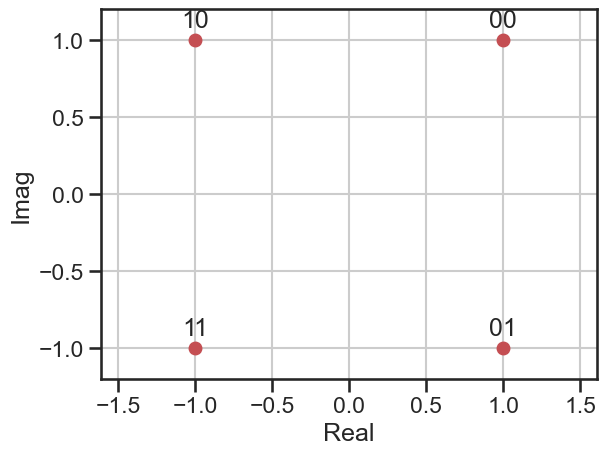

In [17]:
plot_constellation(QPSK)

The modified constellation swaps the bit patters for the two constellation points on the left side.

The code below defines the modified constellation and plots it. Then, we simulate the error rate achieved by this constellation.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


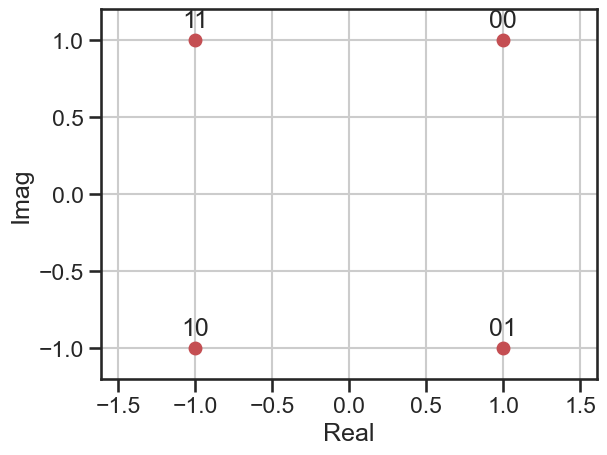

In [18]:
mod_QPSK = {0b00: 1+1j, 0b01:1-1j, 0b10:-1-1j, 0b11: -1+1j} # the modified constellation
plot_constellation(mod_QPSK)

SNR = 0.0 dB: found 493 error in 4096 bits; rate = 0.12036
SNR = 0.5 dB: found 763 error in 8192 bits; rate = 0.09314
SNR = 1.0 dB: found 687 error in 8192 bits; rate = 0.08386
SNR = 1.5 dB: found 562 error in 8192 bits; rate = 0.06860
SNR = 2.0 dB: found 440 error in 8192 bits; rate = 0.05371
SNR = 2.5 dB: found 553 error in 12288 bits; rate = 0.04500
SNR = 3.0 dB: found 528 error in 16384 bits; rate = 0.03223
SNR = 3.5 dB: found 404 error in 16384 bits; rate = 0.02466
SNR = 4.0 dB: found 452 error in 24576 bits; rate = 0.01839
SNR = 4.5 dB: found 404 error in 32768 bits; rate = 0.01233
SNR = 5.0 dB: found 401 error in 45056 bits; rate = 0.00890
SNR = 5.5 dB: found 418 error in 77824 bits; rate = 0.00537
SNR = 6.0 dB: found 407 error in 131072 bits; rate = 0.00311
SNR = 6.5 dB: found 404 error in 180224 bits; rate = 0.00224
SNR = 7.0 dB: found 411 error in 327680 bits; rate = 0.00125
SNR = 7.5 dB: found 401 error in 671744 bits; rate = 0.00060
SNR = 8.0 dB: found 292 error in 1003520 

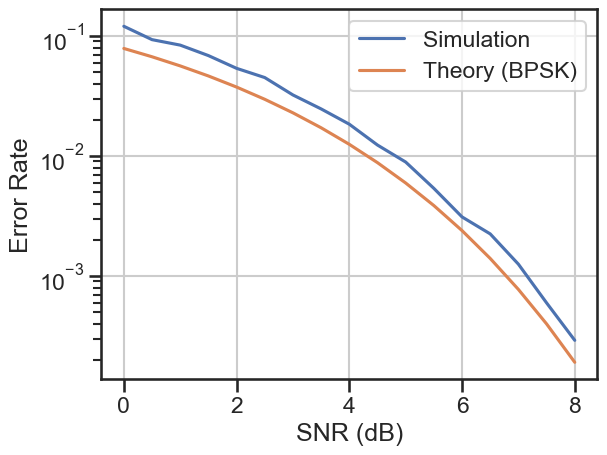

In [19]:
## system parameters
N_burst = 1024*4      # bits in each simulation
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = mod_QPSK

# set SNR range and make storage for Ne and M
SNR_db_vals = np.arange(0, 8.1, 0.5)   # these are in dB, we must convert to linear
Ne_vals = np.zeros(len(SNR_db_vals))
M_vals = np.zeros_like(Ne_vals)

## the simulation loop
for n, SNR_dB in enumerate(SNR_db_vals):
    Ne = 0
    M = 0

    SNR = 10 ** (SNR_dB/10)  # convert dB to linear

    while Ne < 400 and M < 1e6:
        # transmitter
        bits = random_bit_source(N_burst)
        symbols = mod_mapper(bits, constellation)
        tx_sig = pulse_shape(symbols, pulse, fsT)

        # channel

        noise_var = energy_per_bit(constellation) /SNR
        noise_samples = (np.sqrt(0.5*noise_var) * 
                        (np.random.randn(len(tx_sig)) + 1j*np.random.randn(len(tx_sig))))

        rx_sig = tx_sig + noise_samples

        # receiver
        hat_s = matched_filter(rx_sig, pulse, fsT)
        rx_bits = demodulator(hat_s, constellation)

        this_Ne = np.sum(rx_bits != bits)

        # update counters
        Ne += this_Ne
        M += N_burst

    Ne_vals[n] = Ne
    M_vals[n] = M

    print(f"SNR = {SNR_dB} dB: found {Ne} error in {M} bits; rate = {Ne/M:6.5f}")

## plot
plt.semilogy(SNR_db_vals, Ne_vals/M_vals, label='Simulation')
plt.semilogy(SNR_db_vals, Q(np.sqrt(2*10**(SNR_db_vals/10))), label='Theory (BPSK)')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

This is worse!! How is that possible? We're using the same symbols!

* The difference is that in the modified constellation, two pairs of neighboring points differ in both bits. 
  - In the original QPSK, all pairs of neighboring symbols differ in exactly one bit position.
* Two neighboring symbols are most likely to be confused by the receiver.
  - the noise has to be significantly bigger to cause errors involving non-nearest neighbors
  - that's why $d_{min}$ plays such a prominent role in the energy efficiency.
* We get more bit error because in some common error scenarios, we pick up twice as many errors.
* **Insight:** When assigning bits to symbols in a constellation, the patterns assigned to nearest nearest neighbors should differ by only a single bit.
  - this is called *Gray coding*
  - it is not always possible to find a Gray code for a constellation.